In [1]:
import numpy as np
import pandas as pd 
import re
import os
import keras
from keras.preprocessing.text import Tokenizer
from keras.layers import LSTM, Activation, Dropout, Dense, Input
from keras.layers import Dense, Dropout, Embedding, LSTM,Bidirectional,GRU, Conv1D, Flatten
from keras.layers import Embedding
from keras.models import Model
from tensorflow.keras.optimizers import Adam,SGD
import string
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.models import Model
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

/kaggle/input/bangla-glove-global-vectors/bn_glove.39M.100d.txt
/kaggle/input/bangla-glove-global-vectors/bn_glove.100d.txt
/kaggle/input/bangla-glove-global-vectors/bn_glove.300d.txt
/kaggle/input/bangla-glove-global-vectors/bn_glove.39M.300d.txt
/kaggle/input/bangla-stopwords/bangla_stopwords.xlsx
/kaggle/input/sentnob-sentiment-analysis-in-noisy-bangla-texts/SentNoB Dataset/Val.csv
/kaggle/input/sentnob-sentiment-analysis-in-noisy-bangla-texts/SentNoB Dataset/Train.csv
/kaggle/input/sentnob-sentiment-analysis-in-noisy-bangla-texts/SentNoB Dataset/Test.csv


In [2]:
path_to_glove_embds = '/kaggle/input/bangla-glove-global-vectors/bn_glove.39M.300d.txt'
glove = pd.read_csv(path_to_glove_embds, sep=" ", header=None, index_col=0)
glove_embedding = {key: val.values for key, val in glove.T.items()}

In [3]:
df_train = pd.read_csv('/kaggle/input/sentnob-sentiment-analysis-in-noisy-bangla-texts/SentNoB Dataset/Train.csv')
df_test = pd.read_csv('/kaggle/input/sentnob-sentiment-analysis-in-noisy-bangla-texts/SentNoB Dataset/Test.csv')
df_val = pd.read_csv('/kaggle/input/sentnob-sentiment-analysis-in-noisy-bangla-texts/SentNoB Dataset/Val.csv')

In [4]:
df_train.head()

,Data,Label
0,মুগ্ধ হয়ে গেলাম মামু. আর তোমায় কি কমু. বলো তোম...,1
1,এই কুত্তার বাচ্চাদের জন্য দেশটা আজ এমন অবস্তায়...,2
2,ভাই আপনার কথাই যাদু রয়েছে,1
3,উওরটা আমার অনেক ভাল লেগেছে,1
4,আমার নিজের গাড়ী নিয়ে কি সাজেক যেতে পারবো না ?...,0


In [5]:
bn_stopwords = pd.read_excel('/kaggle/input/bangla-stopwords/bangla_stopwords.xlsx')
bn_stopwords = bn_stopwords.drop("Unnamed: 0",axis=1)
bn_stopwords

,word_list
0,অই
1,অগত্যা
2,অত: পর
3,অতএব
4,অথচ
...,...
727,হয়েই
728,হয়েছিল
729,হয়েছে
730,হয়েছেন


In [6]:
stopwords = bn_stopwords['word_list']
stopwords

0          অই
1      অগত্যা
2      অত: পর
3        অতএব
4         অথচ
        ...  
727      হয়েই
728    হয়েছিল
729     হয়েছে
730    হয়েছেন
731       অংশ
Name: word_list, Length: 732, dtype: object

In [7]:
def remove_stopwords(df_train):
    df_train['Data'] = df_train['Data'].apply(lambda x : ' '.join([word for word in x.split() if word not in (stopwords)]))
    return df_train

def remove_tags(string):
    result = re.sub('<.*?>','',string)
    return result
    
df_train = remove_stopwords(df_train)
df_train['Data']= df_train['Data'].apply(lambda cw : remove_tags(cw))


In [8]:
x_train = df_train['Data']
y_train = df_train['Label']
x_test = df_test['Data'] 
y_test = df_test['Label']
x_val = df_val['Data']
y_val = df_val['Label']

In [9]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)
words_to_index = tokenizer.word_index

In [10]:
def read_glove_vector(glove_vec):
    with open(glove_vec, 'r', encoding='UTF-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            w_line = line.split()
            curr_word = w_line[0]
            word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)
    return word_to_vec_map

In [11]:
word_to_vec_map = read_glove_vector("/kaggle/input/bangla-glove-global-vectors/bn_glove.39M.300d.txt")

In [12]:
maxLen = 300
batch_size = 64

In [13]:
vocab_len = len(words_to_index)
embed_vector_len = word_to_vec_map['গাড়ী'].shape[0]

emb_matrix = np.zeros((vocab_len, embed_vector_len))

for word, index in words_to_index.items():
    embedding_vector = word_to_vec_map.get(word)
    if embedding_vector is not None:
        emb_matrix[index, :] = embedding_vector

embedding_layer = Embedding(input_dim=vocab_len, output_dim=embed_vector_len, input_length=maxLen, weights = [emb_matrix], trainable=False)


In [14]:
model= Sequential()
model.add(embedding_layer)
model.add(Conv1D(200, kernel_size=3, activation = "relu"))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.1))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(25, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(12, activation='relu'))
model.add(Flatten())
model.add(Dense(units=6, activation='softmax'))
adam=Adam(learning_rate=0.003)
model.summary()
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          7355700   
                                                                 
 conv1d (Conv1D)             (None, 298, 200)          180200    
                                                                 
 bidirectional (Bidirectiona  (None, 298, 256)         336896    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 298, 256)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

In [15]:
x_train_indices = tokenizer.texts_to_sequences(x_train)
x_train_indices = pad_sequences(x_train_indices, maxlen=maxLen, padding='post')

x_val_indices = tokenizer.texts_to_sequences(x_val)
x_val_indices = pad_sequences(x_val_indices, maxlen=maxLen, padding='post')

x_test_indices = tokenizer.texts_to_sequences(x_test)
x_test_indices = pad_sequences(x_test_indices, maxlen=maxLen, padding='post')

In [16]:
print(x_train_indices.shape)
print(y_train.shape)
print(x_val_indices.shape)
print(y_val.shape)
print(x_test_indices.shape)
print(y_test.shape)

(12575, 300)
(12575,)
(1567, 300)
(1567,)
(1586, 300)
(1586,)


In [17]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

In [18]:
!pip install -q codecarbon
from codecarbon import EmissionsTracker
tracker = EmissionsTracker()

[codecarbon INFO @ 14:43:14] [setup] RAM Tracking...
[codecarbon INFO @ 14:43:14] [setup] GPU Tracking...
[codecarbon INFO @ 14:43:14] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 14:43:14] [setup] CPU Tracking...
[codecarbon WARNING @ 14:43:14] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 14:43:16] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 14:43:16] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 14:43:16] >>> Tracker's metadata:
[codecarbon INFO @ 14:43:16]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 14:43:16]   Python version: 3.10.12
[codecarbon INFO @ 14:43:16]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 14:43:16]   Available RAM : 15.631 GB
[codecarbon INFO @ 14:43:16]   CPU count: 2
[codecarbon INFO @ 14:43:16]   CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 14:43:16]   GPU

In [19]:
%%time 
tracker.start()
history = model.fit(x_train_indices, y_train, batch_size=batch_size, epochs=30, callbacks=[early_stopping], verbose=1, validation_data=(x_val_indices, y_val))
co2_emission = tracker.stop()

Epoch 1/30


[codecarbon INFO @ 14:43:34] Energy consumed for RAM : 0.000024 kWh. RAM Power : 5.8618011474609375 W
[codecarbon INFO @ 14:43:34] Energy consumed for all GPUs : 0.000229 kWh. Total GPU Power : 54.93352338896551 W
[codecarbon INFO @ 14:43:34] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:43:34] 0.000431 kWh of electricity used since the beginning.


197/197 [==============================] - ETA: 0s - loss: 1.1145 - accuracy: 0.4659

[codecarbon INFO @ 14:43:49] Energy consumed for RAM : 0.000049 kWh. RAM Power : 5.8618011474609375 W
[codecarbon INFO @ 14:43:49] Energy consumed for all GPUs : 0.000587 kWh. Total GPU Power : 85.93533876923276 W
[codecarbon INFO @ 14:43:49] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:43:49] 0.000990 kWh of electricity used since the beginning.


197/197 [==============================] - 31s 73ms/step - loss: 1.1145 - accuracy: 0.4659 - val_loss: 0.9064 - val_accuracy: 0.5890
Epoch 2/30
197/197 [==============================] - 12s 60ms/step - loss: 0.9025 - accuracy: 0.5947 - val_loss: 0.8411 - val_accuracy: 0.6299
Epoch 3/30
 36/197 [====>.........................] - ETA: 9s - loss: 0.8560 - accuracy: 0.6324

[codecarbon INFO @ 14:44:04] Energy consumed for RAM : 0.000073 kWh. RAM Power : 5.8618011474609375 W
[codecarbon INFO @ 14:44:04] Energy consumed for all GPUs : 0.000978 kWh. Total GPU Power : 93.84607896990744 W
[codecarbon INFO @ 14:44:04] Energy consumed for all CPUs : 0.000532 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:44:04] 0.001583 kWh of electricity used since the beginning.


197/197 [==============================] - 12s 60ms/step - loss: 0.8039 - accuracy: 0.6574 - val_loss: 0.7832 - val_accuracy: 0.6611
Epoch 4/30
 87/197 [============>.................] - ETA: 6s - loss: 0.7281 - accuracy: 0.6923

[codecarbon INFO @ 14:44:19] Energy consumed for RAM : 0.000098 kWh. RAM Power : 5.8618011474609375 W
[codecarbon INFO @ 14:44:19] Energy consumed for all GPUs : 0.001377 kWh. Total GPU Power : 95.76411576380289 W
[codecarbon INFO @ 14:44:19] Energy consumed for all CPUs : 0.000709 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:44:19] 0.002183 kWh of electricity used since the beginning.


197/197 [==============================] - 12s 63ms/step - loss: 0.7165 - accuracy: 0.7032 - val_loss: 0.7631 - val_accuracy: 0.6733
Epoch 5/30
136/197 [===================>..........] - ETA: 3s - loss: 0.5939 - accuracy: 0.7680

[codecarbon INFO @ 14:44:34] Energy consumed for RAM : 0.000122 kWh. RAM Power : 5.8618011474609375 W


137/197 [===================>..........] - ETA: 3s - loss: 0.5948 - accuracy: 0.7677

[codecarbon INFO @ 14:44:34] Energy consumed for all GPUs : 0.001779 kWh. Total GPU Power : 96.52560768297364 W
[codecarbon INFO @ 14:44:34] Energy consumed for all CPUs : 0.000886 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:44:34] 0.002787 kWh of electricity used since the beginning.


197/197 [==============================] - 12s 62ms/step - loss: 0.6052 - accuracy: 0.7602 - val_loss: 0.7554 - val_accuracy: 0.6777
Epoch 6/30
178/197 [==========================>...] - ETA: 1s - loss: 0.5017 - accuracy: 0.8114

[codecarbon INFO @ 14:44:49] Energy consumed for RAM : 0.000146 kWh. RAM Power : 5.8618011474609375 W
[codecarbon INFO @ 14:44:49] Energy consumed for all GPUs : 0.002180 kWh. Total GPU Power : 96.43944730564388 W
[codecarbon INFO @ 14:44:49] Energy consumed for all CPUs : 0.001063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:44:49] 0.003390 kWh of electricity used since the beginning.


197/197 [==============================] - 13s 64ms/step - loss: 0.5057 - accuracy: 0.8099 - val_loss: 0.7930 - val_accuracy: 0.6822
Epoch 7/30
197/197 [==============================] - 13s 64ms/step - loss: 0.4026 - accuracy: 0.8529 - val_loss: 0.8592 - val_accuracy: 0.6911
Epoch 8/30
 10/197 [>.............................] - ETA: 11s - loss: 0.3019 - accuracy: 0.8875

[codecarbon INFO @ 14:45:04] Energy consumed for RAM : 0.000171 kWh. RAM Power : 5.8618011474609375 W
[codecarbon INFO @ 14:45:04] Energy consumed for all GPUs : 0.002582 kWh. Total GPU Power : 96.42918921109933 W
[codecarbon INFO @ 14:45:04] Energy consumed for all CPUs : 0.001240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:45:04] 0.003993 kWh of electricity used since the beginning.


197/197 [==============================] - 13s 64ms/step - loss: 0.3295 - accuracy: 0.8830 - val_loss: 0.8988 - val_accuracy: 0.6809
Epoch 9/30
 48/197 [======>.......................] - ETA: 9s - loss: 0.2547 - accuracy: 0.9186

[codecarbon INFO @ 14:45:19] Energy consumed for RAM : 0.000195 kWh. RAM Power : 5.8618011474609375 W
[codecarbon INFO @ 14:45:19] Energy consumed for all GPUs : 0.002984 kWh. Total GPU Power : 96.6463810122222 W
[codecarbon INFO @ 14:45:19] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:45:19] 0.004596 kWh of electricity used since the beginning.


197/197 [==============================] - 13s 65ms/step - loss: 0.2780 - accuracy: 0.9049 - val_loss: 0.9682 - val_accuracy: 0.6784
Epoch 10/30
 90/197 [============>.................] - ETA: 6s - loss: 0.2202 - accuracy: 0.9281

[codecarbon INFO @ 14:45:34] Energy consumed for RAM : 0.000220 kWh. RAM Power : 5.8618011474609375 W
[codecarbon INFO @ 14:45:34] Energy consumed for all GPUs : 0.003386 kWh. Total GPU Power : 96.58764321860205 W
[codecarbon INFO @ 14:45:34] Energy consumed for all CPUs : 0.001594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:45:34] 0.005200 kWh of electricity used since the beginning.


197/197 [==============================] - 12s 62ms/step - loss: 0.2363 - accuracy: 0.9194 - val_loss: 1.0038 - val_accuracy: 0.7001
Epoch 11/30
138/197 [====================>.........] - ETA: 3s - loss: 0.1918 - accuracy: 0.9372

[codecarbon INFO @ 14:45:49] Energy consumed for RAM : 0.000244 kWh. RAM Power : 5.8618011474609375 W
[codecarbon INFO @ 14:45:49] Energy consumed for all GPUs : 0.003790 kWh. Total GPU Power : 96.89533564966239 W
[codecarbon INFO @ 14:45:49] Energy consumed for all CPUs : 0.001771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:45:49] 0.005805 kWh of electricity used since the beginning.


197/197 [==============================] - 13s 65ms/step - loss: 0.2040 - accuracy: 0.9315 - val_loss: 1.0594 - val_accuracy: 0.6579
Epoch 12/30
176/197 [=========================>....] - ETA: 1s - loss: 0.1739 - accuracy: 0.9437

[codecarbon INFO @ 14:46:04] Energy consumed for RAM : 0.000268 kWh. RAM Power : 5.8618011474609375 W
[codecarbon INFO @ 14:46:04] Energy consumed for all GPUs : 0.004190 kWh. Total GPU Power : 96.24992943673197 W
[codecarbon INFO @ 14:46:04] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:46:04] 0.006407 kWh of electricity used since the beginning.


197/197 [==============================] - 12s 62ms/step - loss: 0.1728 - accuracy: 0.9437 - val_loss: 1.2303 - val_accuracy: 0.6918
Epoch 13/30
197/197 [==============================] - 12s 63ms/step - loss: 0.1538 - accuracy: 0.9462 - val_loss: 1.0032 - val_accuracy: 0.6739
Epoch 14/30
 13/197 [>.............................] - ETA: 10s - loss: 0.5181 - accuracy: 0.8329

[codecarbon INFO @ 14:46:19] Energy consumed for RAM : 0.000293 kWh. RAM Power : 5.8618011474609375 W
[codecarbon INFO @ 14:46:19] Energy consumed for all GPUs : 0.004593 kWh. Total GPU Power : 96.61253057691988 W
[codecarbon INFO @ 14:46:19] Energy consumed for all CPUs : 0.002125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:46:19] 0.007011 kWh of electricity used since the beginning.


197/197 [==============================] - 13s 65ms/step - loss: 0.2465 - accuracy: 0.9171 - val_loss: 1.1345 - val_accuracy: 0.6950
Epoch 15/30
 51/197 [======>.......................] - ETA: 8s - loss: 0.1293 - accuracy: 0.9565

[codecarbon INFO @ 14:46:34] Energy consumed for RAM : 0.000317 kWh. RAM Power : 5.8618011474609375 W
[codecarbon INFO @ 14:46:34] Energy consumed for all GPUs : 0.004996 kWh. Total GPU Power : 96.94001095560778 W
[codecarbon INFO @ 14:46:34] Energy consumed for all CPUs : 0.002302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:46:34] 0.007616 kWh of electricity used since the beginning.


197/197 [==============================] - 12s 63ms/step - loss: 0.1366 - accuracy: 0.9548 - val_loss: 1.0962 - val_accuracy: 0.7007


[codecarbon INFO @ 14:46:43] Energy consumed for RAM : 0.000332 kWh. RAM Power : 5.8618011474609375 W
[codecarbon INFO @ 14:46:43] Energy consumed for all GPUs : 0.005248 kWh. Total GPU Power : 96.99355960941065 W
[codecarbon INFO @ 14:46:43] Energy consumed for all CPUs : 0.002413 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:46:43] 0.007993 kWh of electricity used since the beginning.


CPU times: user 3min 24s, sys: 6.96 s, total: 3min 31s
Wall time: 3min 24s


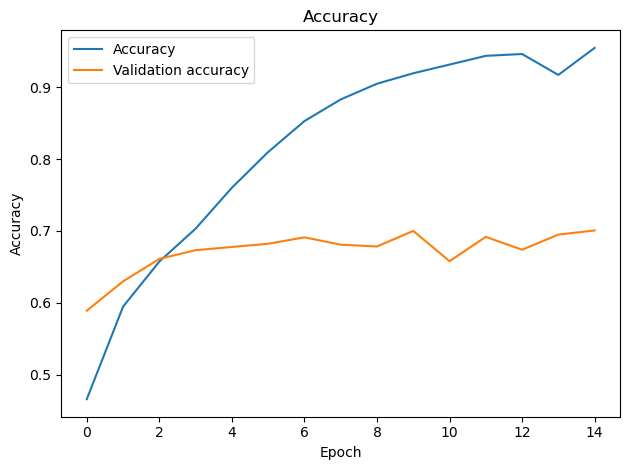

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label="Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation accuracy")
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

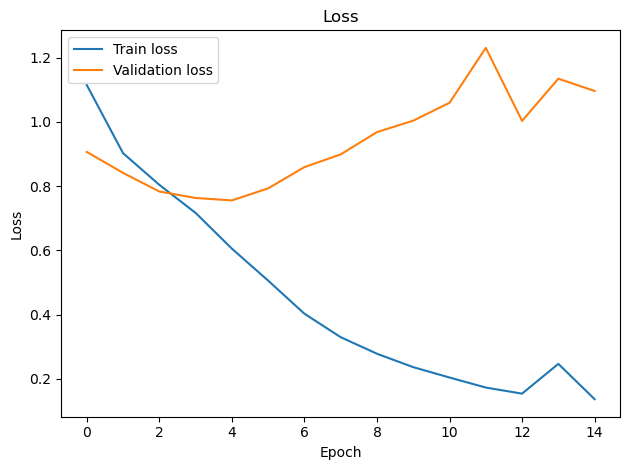

In [21]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label="Train loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
predictions = model.predict(x_test_indices)
predictions = np.argmax(predictions,axis=1)
ground_truth_labels = y_test

50/50 [==============================] - 2s 23ms/step


In [23]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

accuracy = accuracy_score(ground_truth_labels, predictions)
f1_macro = f1_score(ground_truth_labels, predictions, average='macro')
f1_micro = f1_score(ground_truth_labels, predictions, average='micro')

precision = precision_score(ground_truth_labels, predictions, average="weighted")
recall = recall_score(ground_truth_labels, predictions, average="weighted")
class_report = classification_report(ground_truth_labels, predictions)
conf_matrix = confusion_matrix(ground_truth_labels, predictions)

print("Accuracy:", accuracy)
print("F1 Macro:", f1_macro)
print("F1 Micro:", f1_micro)
print('Precision:', precision)
print("Recall:", recall)
print("Classification Report:\n", class_report)
print("Confusion Matrix: \n", conf_matrix)
print('Total CO2 emissions in grams: \n',co2_emission*1000)

Accuracy: 0.6412358133669609
F1 Macro: 0.6019195708613715
F1 Micro: 0.6412358133669609
Precision: 0.6376618943763088
Recall: 0.6412358133669609
Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.36      0.40       361
           1       0.75      0.68      0.72       654
           2       0.63      0.77      0.69       571

    accuracy                           0.64      1586
   macro avg       0.61      0.60      0.60      1586
weighted avg       0.64      0.64      0.63      1586

Confusion Matrix: 
 [[129  90 142]
 [ 85 447 122]
 [ 72  58 441]]
Total CO2 emissions in grams: 
 2.282006629457853
